In [ ]:
#!pip install shap

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn import mixture

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, ParameterGrid, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from torch import nn, Tensor, sigmoid, round as t_round
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Adam, SGD, NAdam
from torch.nn import Linear, ReLU, Tanh, BatchNorm1d, BCEWithLogitsLoss

import scipy.stats as ss
from tqdm import tqdm
import shap

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn')

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
cd /content/cardio

/content/cardio


In [6]:
!pwd

/content/cardio


In [7]:
train = pd.read_csv('train.csv', sep = ';')
test = pd.read_csv('test.csv', sep = ';')

In [8]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [9]:
test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,None,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,None,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


In [10]:
#drop unique ids

train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

In [11]:
#convert gender to 0 and 1

train['gender'] -= 1
test['gender'] -= 1

In [12]:
train.shape, test.shape

((70000, 12), (30000, 11))

In [13]:
#convert age from days into years

train['age'] = round(train.age/365.25)
test['age'] = round(test.age/365.25)

# EDA

In [14]:
print(train.info())
print()
print('='*50)
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.4 MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          30000 non-null  float64
 1   gende

In [15]:
#The test dataset reveals missing values filled with 'None'

for col in test.columns:
    if 'None' in test[col].values:
        print(col, 'contains NaN values')
    else:
        print('No such values in', col)

No such values in age
No such values in gender
No such values in height
No such values in weight
No such values in ap_hi
No such values in ap_lo
No such values in cholesterol
No such values in gluc
smoke contains NaN values
alco contains NaN values
active contains NaN values


In [16]:
test.replace('None', np.NaN, inplace = True)

In [17]:
#The training data contains no such values

for col in train.columns:
    if 'None' in train[col].values:
        print(col, 'contains NaN values')
    else:
        print('No such values in', col)

No such values in age
No such values in gender
No such values in height
No such values in weight
No such values in ap_hi
No such values in ap_lo
No such values in cholesterol
No such values in gluc
No such values in smoke
No such values in alco
No such values in active
No such values in cardio


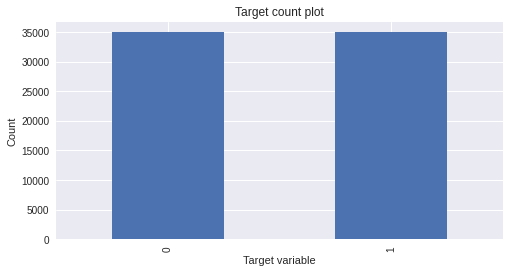

In [ ]:
#Looks like we have a balanced dataset, which is nice

plt.figure(figsize = (8, 4))
train['cardio'].value_counts().plot(kind = 'bar')
plt.title('Target count plot')
plt.xlabel('Target variable')
plt.ylabel('Count')
plt.show()

Let's take a sample of size 1000 and visualize the distributions. The plots below confirm some common indicators of heart disease. For example, older people are more prone to heart issues, as are people that have higher systolic pressure values. Low glucose and cholesterol seem to be associated with normal heart condition. People with no heart problems tend to be more active.   

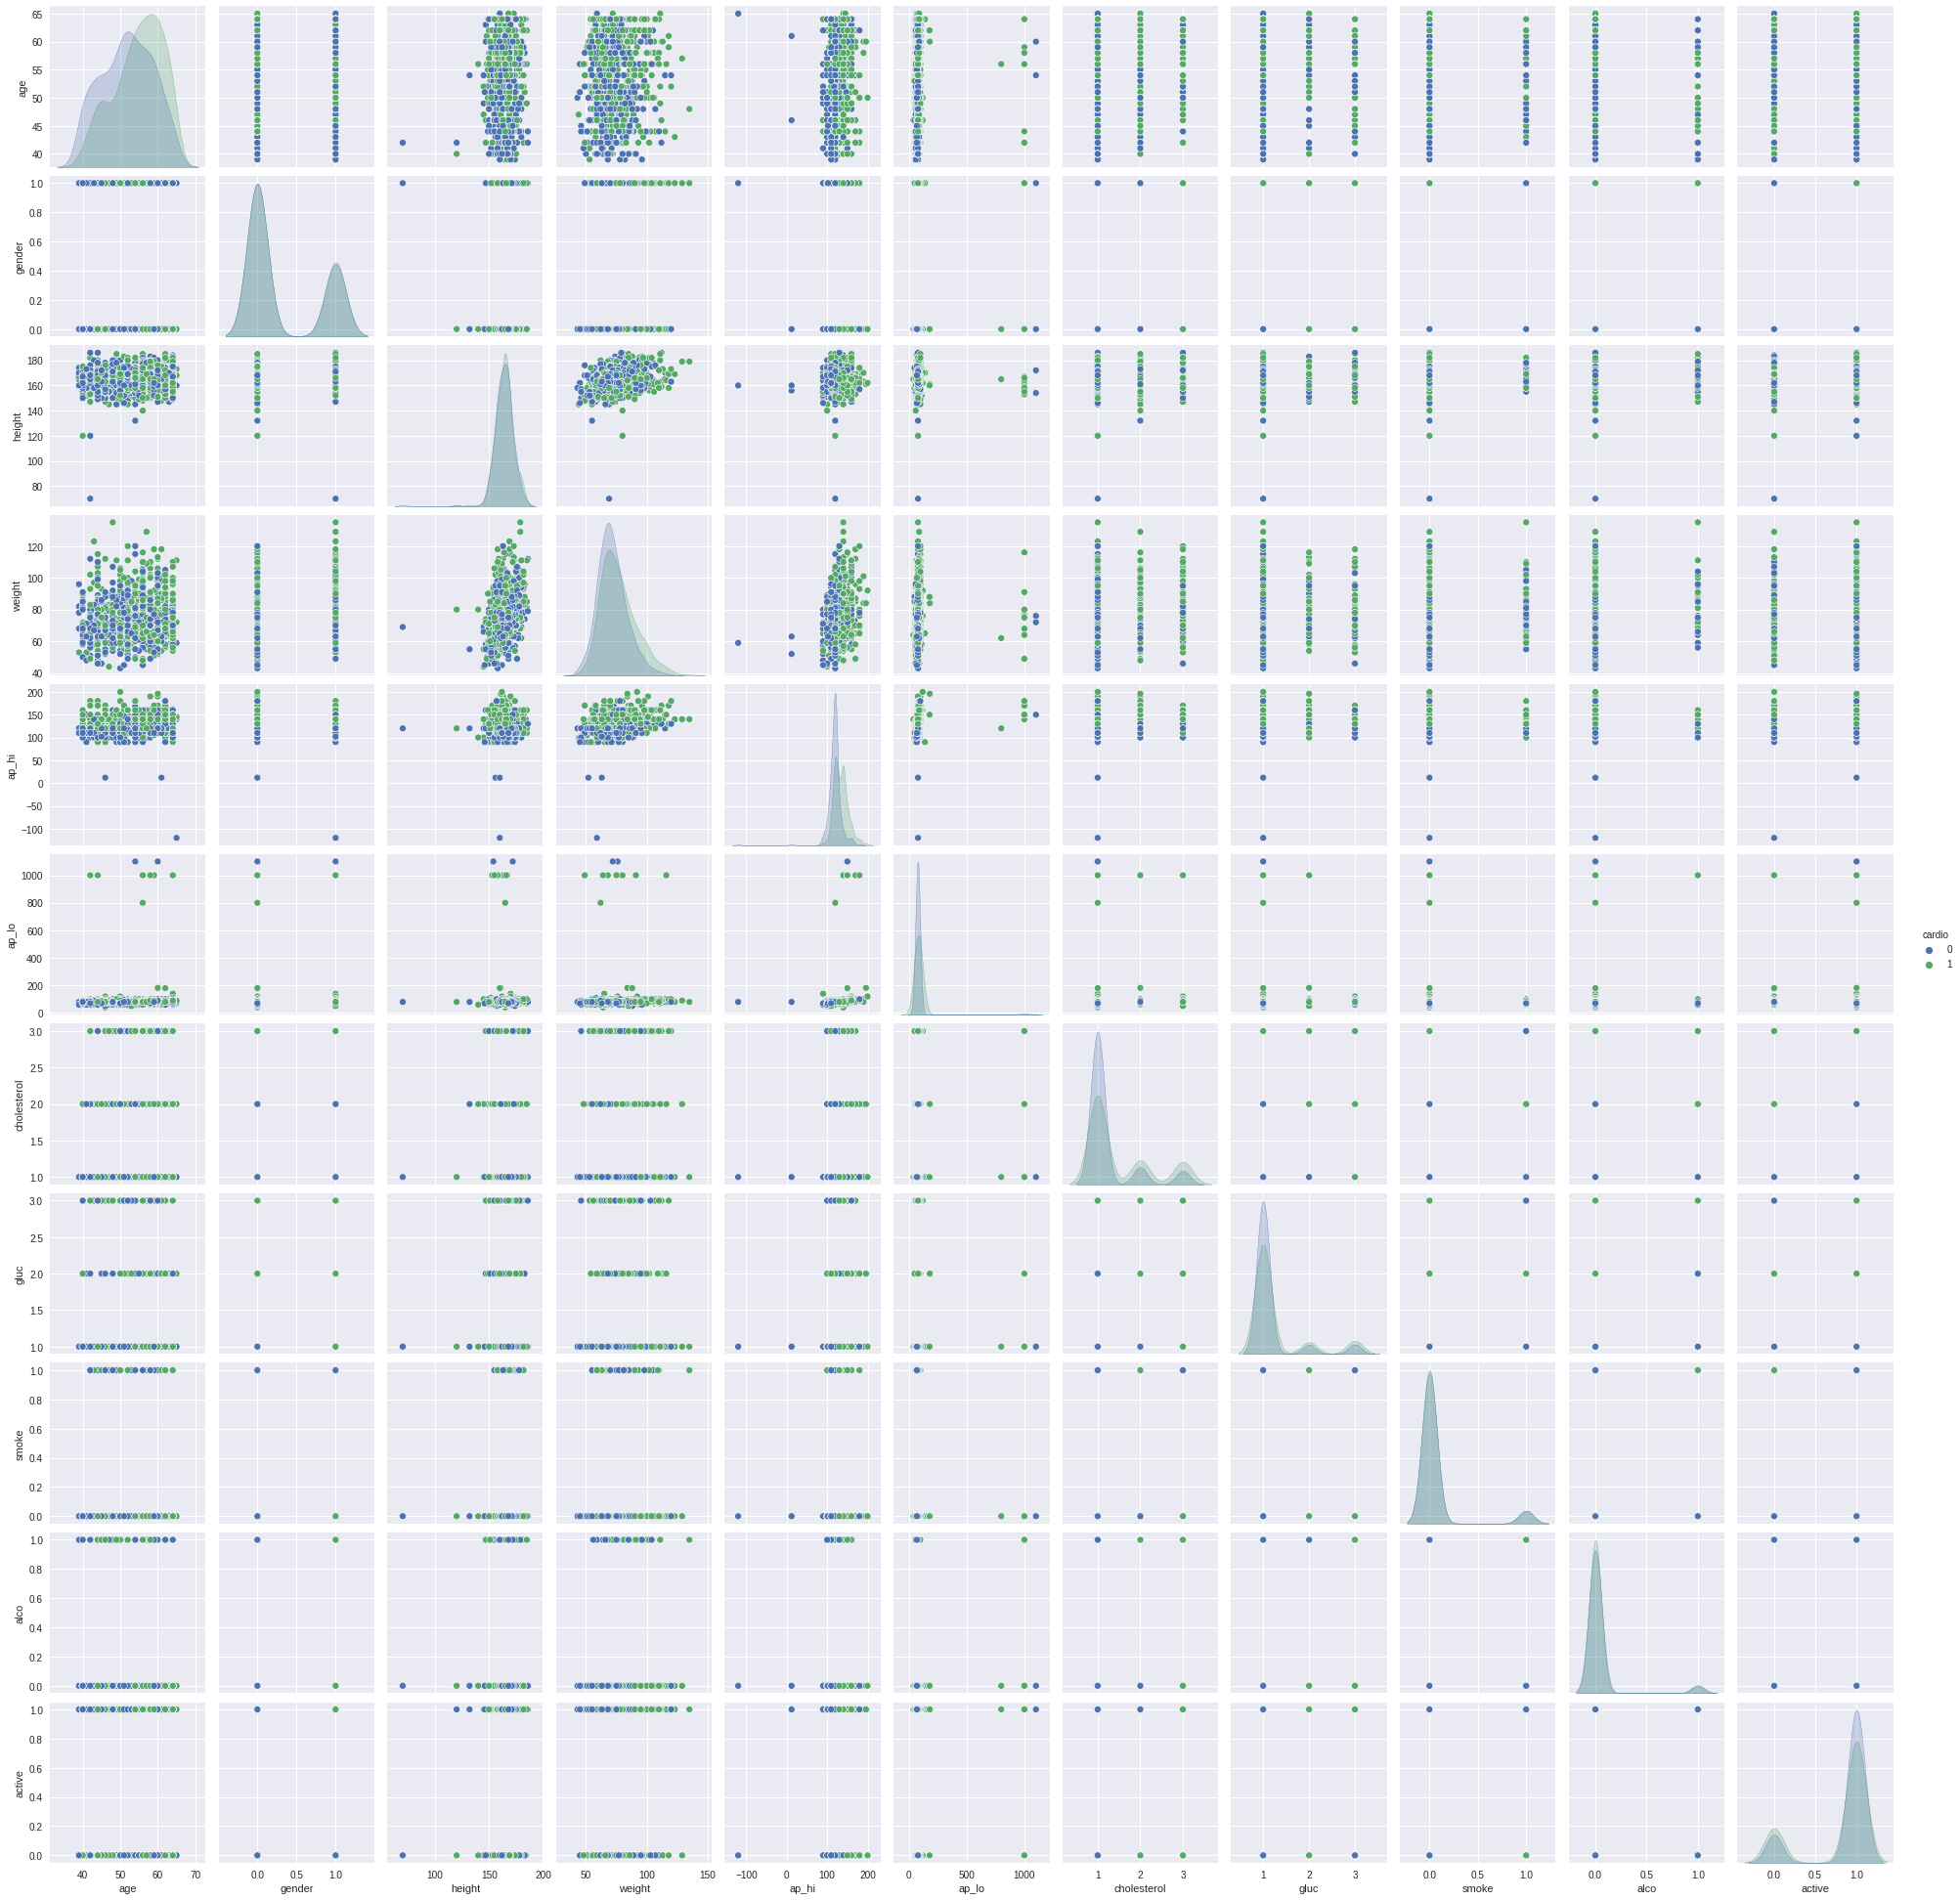

In [18]:
sns.pairplot(train.sample(n = 1000, random_state = 444), hue = 'cardio')

In [19]:
#Let's merge the two datasets to handle missing values and do some data cleaning

all_data = train.drop('cardio', axis = 1).append(test).reset_index(drop = True)

# Handling missing values

There are a number of strategies to handle missing categorical values. The one I'm going to try here would be to groupby by several other attributes and replace NaNs with modes for each such feature.

First, we will take care of the Active feature. We might want to split the age variable into several age clusters, then group by age cluster and gender to determine if the majority of the people within these groups are active or not, then fill the NaNs accordingly. 

Second, we will take care of the Alco and Smoke features. We will group by age cluster, gender and active to determine if the majority of the people within these groups smoke or drink, then fill the NaNs accordingly. 

In [20]:
all_data.isna().sum()

age               0
gender            0
height            0
weight            0
ap_hi             0
ap_lo             0
cholesterol       0
gluc              0
smoke          3030
alco           3031
active         2897
dtype: int64

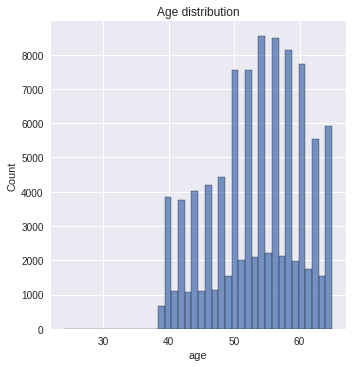

In [21]:
#Looks like the Age variable has 13 distinct peaks

sns.displot(all_data, x = 'age', bins = 40, fill = True)
plt.title('Age distribution')
plt.show()

In [22]:
gmm = mixture.GaussianMixture(n_components = 13, random_state = 22).fit(all_data['age'].values.reshape(-1, 1))
labels = gmm.predict(all_data['age'].values.reshape(-1, 1))
all_data['age_group'] = labels
print('Num of clusters: {}'.format(len(np.unique(labels))))

Num of clusters: 13


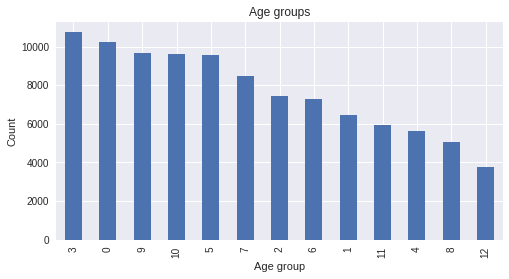

In [23]:
plt.figure(figsize = (8, 4))
all_data['age_group'].value_counts().plot(kind = 'bar')
plt.title('Age groups')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

In [24]:
all_data[['active', 'alco', 'smoke']] = all_data[['active', 'alco', 'smoke']].replace({'0': 0, '1': 1})

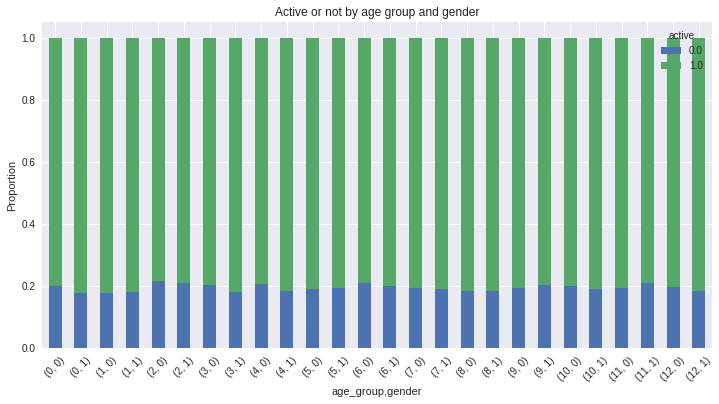

In [25]:
active_mode_viz_data = all_data.dropna(axis = 0, subset = ['active'])
pd.crosstab(index = [active_mode_viz_data['age_group'], active_mode_viz_data['gender']], 
            columns = [active_mode_viz_data['active']], normalize='index').plot.bar(figsize = (12, 6), 
                                                                                    rot = 45, 
                                                                                    stacked = True)
plt.title('Active or not by age group and gender')
plt.ylabel('Proportion')
plt.show()

In [26]:
#looks like the majority of the people of all age groups and genders lead an active lifestyle
#so we fill the missing Active values with 1

all_data['active'].fillna(1, inplace = True)

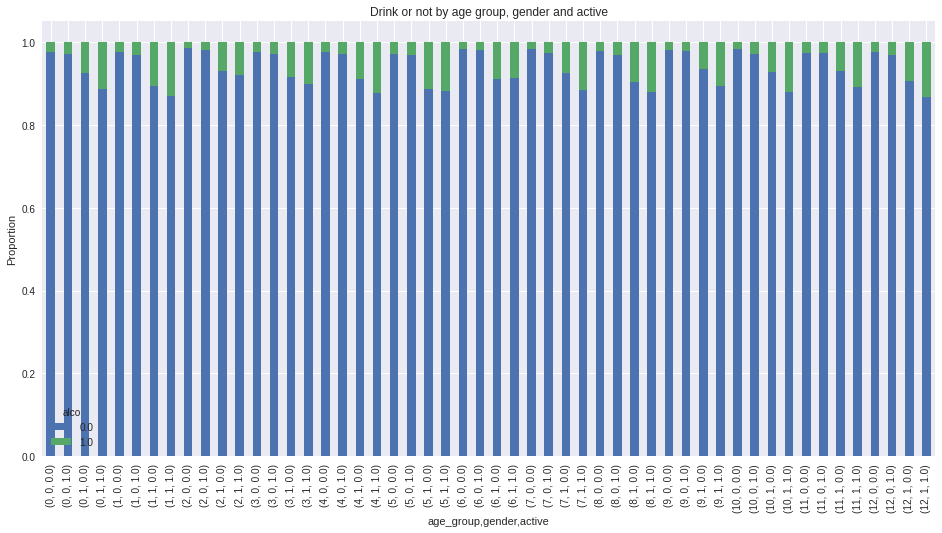

In [27]:
alco_mode_viz_data = all_data.dropna(axis = 0, subset = ['alco'])
pd.crosstab(index = [alco_mode_viz_data['age_group'], alco_mode_viz_data['gender'], alco_mode_viz_data['active']], 
            columns = [alco_mode_viz_data['alco']], normalize='index').plot.bar(figsize = (16, 8), 
                                                                                    rot = 90, 
                                                                                    stacked = True)
plt.title('Drink or not by age group, gender and active')
plt.ylabel('Proportion')
plt.show()

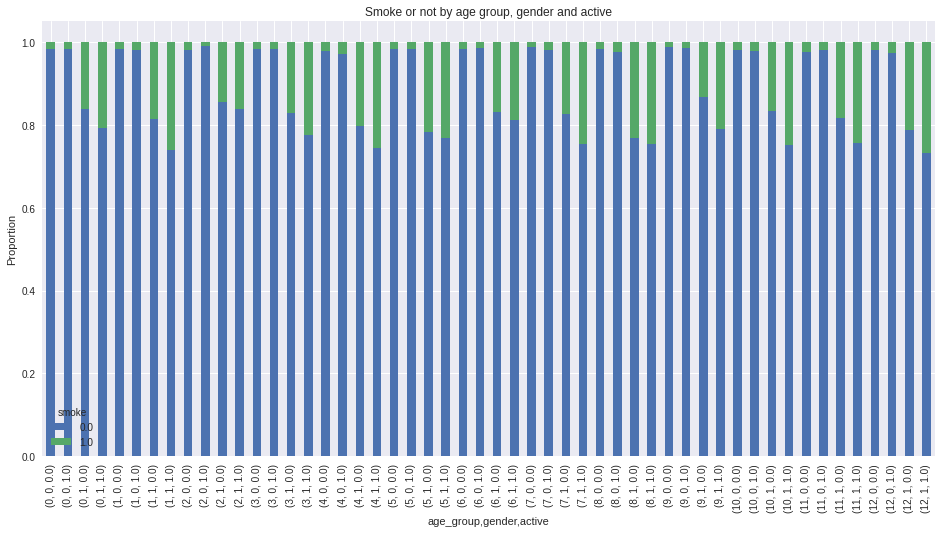

In [28]:
smoke_mode_viz_data = all_data.dropna(axis = 0, subset = ['smoke'])
pd.crosstab(index = [smoke_mode_viz_data['age_group'], smoke_mode_viz_data['gender'], smoke_mode_viz_data['active']], 
            columns = [smoke_mode_viz_data['smoke']], normalize='index').plot.bar(figsize = (16, 8), 
                                                                                    rot = 90, 
                                                                                    stacked = True)
plt.title('Smoke or not by age group, gender and active')
plt.ylabel('Proportion')
plt.show()

In [29]:
#looks like the majority of the people of all age groups, genders and lifestyles neither smoke nor drink
#so we fill the missing Smoke and Alco values with 0

all_data['alco'].fillna(0, inplace = True)
all_data['smoke'].fillna(0, inplace = True)

In [30]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   age          100000 non-null  float64
 1   gender       100000 non-null  int64  
 2   height       100000 non-null  int64  
 3   weight       100000 non-null  float64
 4   ap_hi        100000 non-null  int64  
 5   ap_lo        100000 non-null  int64  
 6   cholesterol  100000 non-null  int64  
 7   gluc         100000 non-null  int64  
 8   smoke        100000 non-null  float64
 9   alco         100000 non-null  float64
 10  active       100000 non-null  float64
 11  age_group    100000 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 9.2 MB


# Data cleaning

In this section we will do some data cleaning for the ap_hi, ap_lo, height and weight columns as these contain a lot of outliers.

In [31]:
#Let's take a closer look at our data

all_data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_group
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,53.292860,0.350820,164.348140,74.180167,129.253490,96.347990,1.367220,1.225330,0.085380,0.052330,0.810010,5.621200
std,6.769565,0.477229,8.211187,14.379494,173.639687,181.437372,0.679922,0.570543,0.279448,0.222693,0.392295,3.631449
min,24.000000,0.000000,50.000000,10.000000,-150.000000,-90.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.000000
50%,54.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,9.000000
max,65.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,12.000000


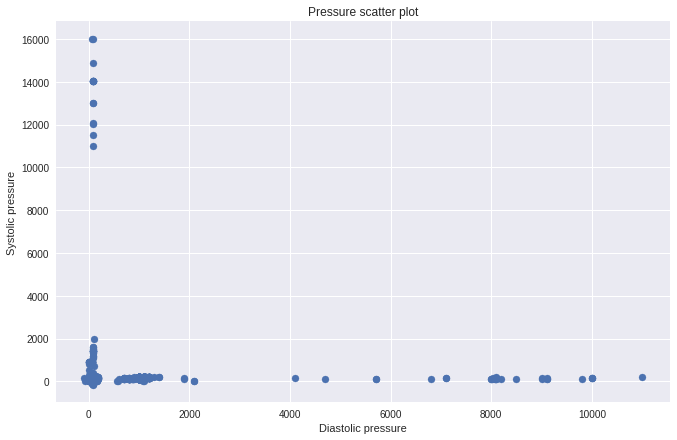

In [32]:
#let's handle the pressure columns first

fig = plt.figure(figsize = (11, 7))
plt.scatter(all_data['ap_lo'], all_data['ap_hi'])
plt.xlabel('Diastolic pressure')
plt.ylabel('Systolic pressure')
plt.title('Pressure scatter plot')
plt.show()

In [33]:
def round_pressure(x, base = 5):
    return base * round(x/base)

In [34]:
all_data['ap_hi'] = all_data['ap_hi'].apply(lambda x: x * (-1) if x < 0 else x)

all_data['ap_hi'] = all_data['ap_hi'].apply(lambda x: x * 10 if x < 30 else x)
all_data['ap_hi'] = all_data['ap_hi'].apply(lambda x: x * 10 if x < 30 else x)

all_data['ap_hi'] = all_data['ap_hi'].apply(lambda x: x / 10 if 300 < x <= 3000 else x)
all_data['ap_hi'] = all_data['ap_hi'].apply(lambda x: x / 100 if x > 3000 else x)

all_data['ap_lo'] = all_data['ap_lo'].apply(lambda x: x * (-1) if x < 0 else x)

all_data['ap_lo'] = all_data['ap_lo'].apply(lambda x: x * 10 if x < 30 else x)
all_data['ap_lo'] = all_data['ap_lo'].apply(lambda x: x * 10 if x < 30 else x)

all_data['ap_lo'] = all_data['ap_lo'].apply(lambda x: x / 10 if 300 <= x <= 1800 else x)

all_data['ap_lo'] = all_data['ap_lo'].apply(lambda x: x / 100 if x > 1800 else x)

all_data.loc[(180 <= all_data['ap_lo']) \
             & (all_data['ap_lo'] < 300) \
             & (all_data['ap_hi'] <= 100), 'ap_lo'] = 60

all_data.loc[(180 <= all_data['ap_lo']) \
             & (all_data['ap_lo'] < 300) \
             & (110 <= all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 130), 'ap_lo'] = 80

all_data.loc[(180 <= all_data['ap_lo']) \
             & (all_data['ap_lo'] < 300) \
             & (130 < all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 160), 'ap_lo'] = 90

all_data.loc[(180 <= all_data['ap_lo']) \
             & (all_data['ap_lo'] < 300) \
             & (all_data['ap_hi'] > 160), 'ap_lo'] = 100

all_data.loc[(all_data['ap_lo'] == 0) \
             & (all_data['ap_hi'] <= 100), 'ap_lo'] = 60

all_data.loc[(all_data['ap_lo'] == 0) \
             & (110 <= all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 130), 'ap_lo'] = 80

all_data.loc[(all_data['ap_lo'] == 0) \
             & (130 < all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 160), 'ap_lo'] = 90

all_data.loc[(all_data['ap_lo'] == 0) \
             & (all_data['ap_hi'] > 160), 'ap_lo'] = 100

all_data.loc[(all_data['ap_lo'] < 30) \
             & (all_data['ap_hi'] <= 100), 'ap_lo'] = 60

all_data.loc[(all_data['ap_lo'] < 30) \
             & (110 <= all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 130), 'ap_lo'] = 80

all_data.loc[(all_data['ap_lo'] < 30) \
             & (130 < all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 160), 'ap_lo'] = 90

all_data.loc[(all_data['ap_lo'] < 30) \
             & (all_data['ap_hi'] > 160), 'ap_lo'] = 100

all_data.loc[(all_data['ap_lo'] == 0), 'ap_lo'] = 80

#swap ap_lo with ap_hi in case ap_lo is greater than ap_hi 
x = all_data.loc[all_data.ap_lo > all_data.ap_hi, ['ap_lo', 'ap_hi']]
x.columns = ['ap_hi', 'ap_lo']
all_data.loc[all_data.ap_lo > all_data.ap_hi, ['ap_hi', 'ap_lo']] = x

all_data.loc[(all_data.ap_lo == all_data.ap_hi), ['ap_hi', 'ap_lo']] = all_data['ap_hi'].median(), all_data['ap_lo'].median()

all_data['ap_hi'] = all_data['ap_hi'].apply(lambda x: round_pressure(x))
all_data['ap_lo'] = all_data['ap_lo'].apply(lambda x: round_pressure(x))

all_data.loc[(all_data['ap_lo'] < 50) \
             & (all_data['ap_hi'] < 90), 'ap_lo'] = 50

all_data.loc[(all_data['ap_lo'] < 50) \
             & (90 <= all_data['ap_hi']) \
             & (all_data['ap_hi'] < 100), 'ap_lo'] = 60

all_data.loc[(all_data['ap_lo'] < 50) \
             & (100 <= all_data['ap_hi']) \
             & (all_data['ap_hi'] < 110), 'ap_lo'] = 70

all_data.loc[(all_data['ap_lo'] < 50) \
             & (110 <= all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 130), 'ap_lo'] = 80

all_data.loc[(all_data['ap_lo'] < 50) \
             & (130 < all_data['ap_hi']) \
             & (all_data['ap_hi'] <= 160), 'ap_lo'] = 90

all_data.loc[(all_data['ap_lo'] < 50) \
             & (all_data['ap_hi'] > 160), 'ap_lo'] = 100

all_data.loc[(all_data['ap_lo'] > 130), 'ap_lo'] = 130

all_data.loc[(all_data['ap_hi'] < 80), 'ap_hi'] = 80

all_data.loc[((all_data['ap_hi'] - all_data['ap_lo']) < 10) \
             & (all_data['ap_hi'] <= 100), 'ap_lo'] = 70

all_data.loc[((all_data['ap_hi'] - all_data['ap_lo']) < 10) \
             & (all_data['ap_hi'] > 100), 'ap_lo'] = 80

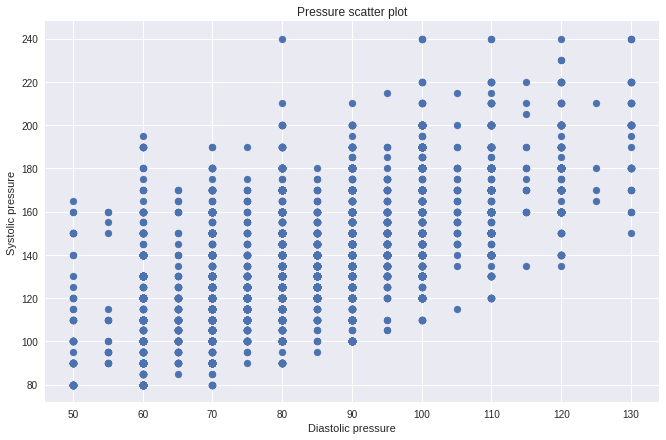

In [35]:
#let's plot the results

#this looks much better now

fig = plt.figure(figsize = (11, 7))
plt.scatter(all_data['ap_lo'], all_data['ap_hi'])
plt.xlabel('Diastolic pressure')
plt.ylabel('Systolic pressure')
plt.title('Pressure scatter plot')
plt.show()

In [36]:
all_data[['ap_hi', 'ap_lo']].describe()

,ap_hi,ap_lo
count,100000.000000,100000.000000
mean,127.071150,81.602800
std,17.017975,9.648521
min,80.000000,50.000000
25%,120.000000,80.000000
50%,120.000000,80.000000
75%,140.000000,90.000000
max,240.000000,130.000000


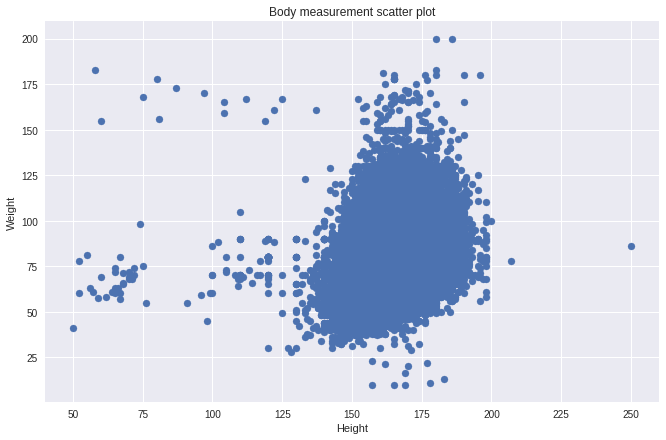

In [37]:
#now we'll take care of the height and weight columns

fig = plt.figure(figsize = (11, 7))
plt.scatter(all_data['height'], all_data['weight'])
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Body measurement scatter plot')
plt.show()

[]

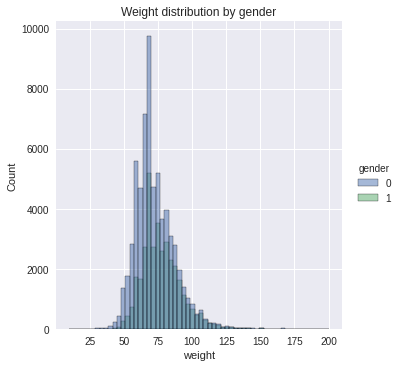

In [38]:
sns.displot(all_data, x = 'weight', hue = 'gender', bins = 60, fill = True)
plt.title('Weight distribution by gender')
plt.plot()

[]

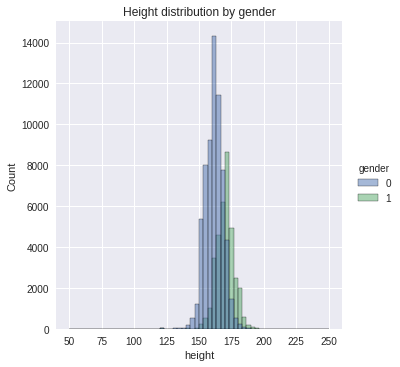

In [39]:
sns.displot(all_data, x = 'height', hue = 'gender', bins = 60, fill = True)
plt.title('Height distribution by gender')
plt.plot()

In [40]:
x = all_data.loc[all_data.weight > all_data.height, ['weight', 'height']]
x.columns = ['height', 'weight']
all_data.loc[all_data.weight > all_data.height, ['height', 'weight']] = x

all_data['height'] = all_data['height'].apply(lambda x: x + 100 if x <= 100 else x)

all_data.loc[(all_data['height'] < 147) \
             & (all_data['gender'] == 0), 'height'] = all_data[all_data['gender'] == 0]['height'].median()

all_data.loc[(all_data['height'] < 147) \
             & (all_data['gender'] == 1), 'height'] = all_data[all_data['gender'] == 1]['height'].median()

all_data.loc[(all_data['height'] > 200) \
             & (all_data['gender'] == 0), 'height'] = all_data[all_data['gender'] == 0]['height'].median()

all_data.loc[(all_data['height'] > 200) \
             & (all_data['gender'] == 1), 'height'] = all_data[all_data['gender'] == 1]['height'].median()

all_data.loc[(all_data['weight'] < 35) \
             & (all_data['gender'] == 0), 'weight'] = all_data[all_data['gender'] == 0]['weight'].median()

all_data.loc[(all_data['weight'] < 40) \
             & (all_data['gender'] == 1), 'weight'] = all_data[all_data['gender'] == 1]['weight'].median()

all_data.loc[(all_data['weight'] > 145) \
             & (all_data['gender'] == 0), 'weight'] = all_data[all_data['gender'] == 0]['weight'].median()

all_data.loc[(all_data['weight'] > 145) \
             & (all_data['gender'] == 1), 'weight'] = all_data[all_data['gender'] == 1]['weight'].median()

all_data.loc[(all_data.weight >= all_data.height - 30) \
             & (all_data['gender'] == 0), 'weight'] = all_data[all_data['gender'] == 0]['weight'].median()

all_data.loc[(all_data.weight >= all_data.height - 30) \
             & (all_data['gender'] == 1), 'weight'] = all_data[all_data['gender'] == 1]['weight'].median()

all_data.loc[((all_data.height - all_data.weight) > 130) \
             & (all_data['gender'] == 0), 'weight'] = all_data[all_data['gender'] == 0]['weight'].median()

all_data.loc[((all_data.height - all_data.weight) > 125) \
             & (all_data['gender'] == 1), 'weight'] = all_data[all_data['gender'] == 1]['weight'].median()

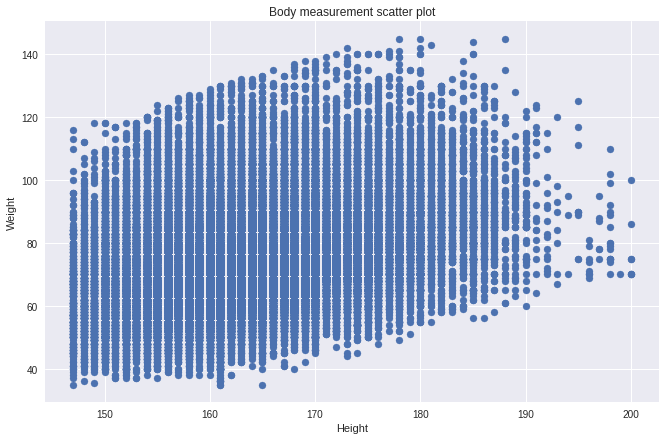

In [41]:
#plot the results

fig = plt.figure(figsize = (11, 7))
plt.scatter(all_data['height'], all_data['weight'])
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Body measurement scatter plot')
plt.show()

In [42]:
all_data[['height', 'weight']].describe()

,height,weight
count,100000.00000,100000.000000
mean,164.58501,74.042604
std,7.61669,13.915284
min,147.00000,35.000000
25%,159.00000,65.000000
50%,165.00000,72.000000
75%,170.00000,82.000000
max,200.00000,145.000000


# Feature engineering

Generate some additional features

In [43]:
#body mass index aka BMI
all_data['BMI'] = all_data['weight'] / ((all_data['height'] / 100)**2)

#pressure difference
all_data['pressure_diff'] = all_data['ap_hi'] - all_data['ap_lo']

[]

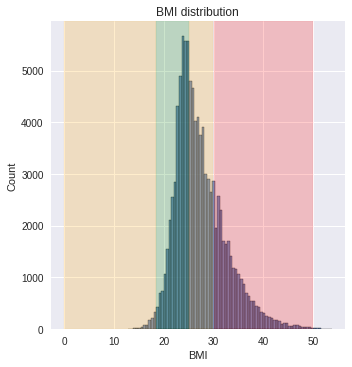

In [44]:
sns.displot(all_data, x = 'BMI', bins = 80, fill = True)
plt.title('BMI distribution')
plt.axvspan(0, 18.5, alpha = 0.2, color = 'orange')
plt.axvspan(18.5, 25, alpha = 0.2, color = 'green')
plt.axvspan(25, 29.9, alpha = 0.2, color = 'orange')
plt.axvspan(30, 50, alpha = 0.2, color = 'red')
plt.plot()

[]

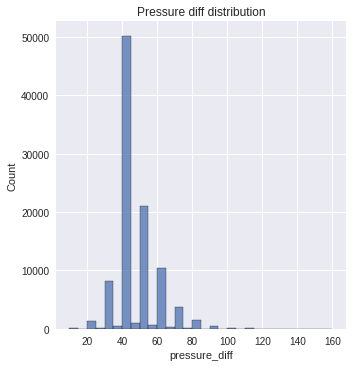

In [45]:
sns.displot(all_data, x = 'pressure_diff', bins = 30, fill = True)
plt.title('Pressure diff distribution')
plt.plot()

In [46]:
#create categories from BMI

conditions_BMI = [(all_data['BMI'] < 18.5),
                  (all_data['BMI'] >= 18.5) & (all_data['BMI'] <= 25),
                  (all_data['BMI'] > 25) & (all_data['BMI'] <= 30),
                  (all_data['BMI'] > 30)]

values_BMI = ['Thin', 'Normal', 'Overweight', 'Obese']

all_data['BMI_category'] = np.select(conditions_BMI, values_BMI)

In [47]:
#create categories from pressure

conditions_pressure = [(all_data['ap_hi'] < 120) & (all_data['ap_lo'] < 80),
                       (all_data['ap_hi'] >= 120) & (all_data['ap_hi'] <= 129) & (all_data['ap_lo'] < 80),
                       ((all_data['ap_hi'] > 129) & (all_data['ap_hi'] < 140)) | ((all_data['ap_lo'] >= 80) & (all_data['ap_lo'] < 90)),
                       ((all_data['ap_hi'] >= 140) & (all_data['ap_hi'] <= 180)) | ((all_data['ap_lo'] >= 90) & (all_data['ap_lo'] <= 120)),
                       (all_data['ap_hi'] > 180) | (all_data['ap_lo'] > 120)]

values_pressure = ['Healthy', 'Elevated', 'Stage 1 hypertension', 
                   'Stage 2 hypertension', 'Hypertension crisis']

all_data['Pressure_category'] = np.select(conditions_pressure, values_pressure)

In [48]:
all_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_group,BMI,pressure_diff,BMI_category,Pressure_category
0,50.0,1,168.0,62.0,110,80,1,1,0.0,0.0,1.0,5,21.967120,30,Normal,Stage 1 hypertension
1,55.0,0,156.0,85.0,140,90,3,1,0.0,0.0,1.0,3,34.927679,50,Obese,Stage 2 hypertension
2,52.0,0,165.0,64.0,130,70,3,1,0.0,0.0,0.0,10,23.507805,60,Normal,Stage 1 hypertension
3,48.0,1,169.0,82.0,150,100,1,1,0.0,0.0,1.0,11,28.710479,50,Overweight,Stage 2 hypertension
4,48.0,0,156.0,56.0,100,60,1,1,0.0,0.0,0.0,11,23.011177,40,Normal,Healthy


# Feature selection

In this section we will plot correlations between different variables and then use filter and built-in methods to select N best features

In [49]:
#function for calculating Cramer's V

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [50]:
#we will use Cramer's V to measure association between the categorical variables

cat_columns = ['gender', 'cholesterol',	'gluc',	'smoke', 
               'alco', 'active', 'age_group', 'BMI_category',	'Pressure_category']

cat_matrix = pd.DataFrame(index = all_data[cat_columns].columns, columns = all_data[cat_columns].columns)
columns = all_data[cat_columns].columns

for i in columns:
    for j in columns:
        
        cr = cramers_v(all_data[i], all_data[j])
        cat_matrix.loc[i, j] = cr

cat_matrix.fillna(value = np.nan, inplace = True)

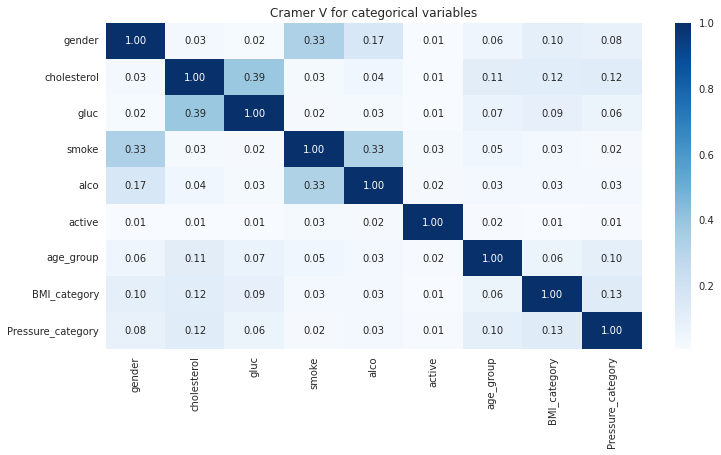

In [51]:
plt.figure(figsize = (12, 6))
sns.heatmap(cat_matrix, cmap = 'Blues', annot = True, fmt = '.2f')
plt.title('Cramer V for categorical variables', size = 12)
sns.set(font_scale = 0.7)
plt.show()

In [52]:
#we will use Pearson coefficient to measure correlation between the numerical variables 

num_columns = ['age',	'height',	'weight', 'ap_hi', 'ap_lo', 'BMI', 'pressure_diff']

num_matrix = all_data[num_columns].corr()

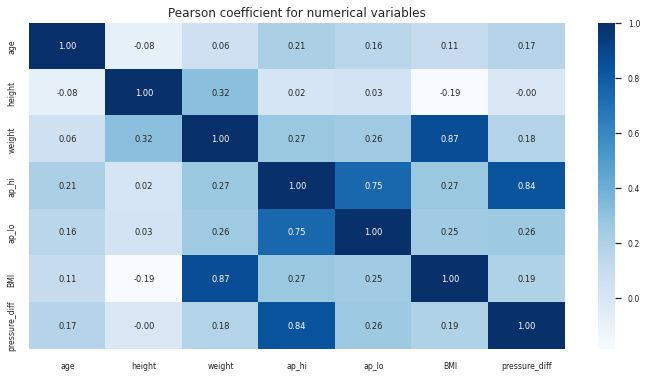

In [53]:
plt.figure(figsize = (12, 6))
sns.heatmap(num_matrix, cmap = 'Blues', annot = True, fmt = '.2f')
plt.title('Pearson coefficient for numerical variables', size = 12)
sns.set(font_scale = 0.7)
plt.show()

While all the categorical features are weakly correlated, there's obviously a strong correlation between some numerical features. Now we're going to do feature selection to determine if there are any features that can be safely removed. We will start with popular filter methods and then use an RF classifier with default parameters to determine the importance of each feature and set the baseline for more complex models to beat.

The output is categorical while the input contains both numerical and categorical variables. We will use the ANOVA correlation coefficient for the numerical features and the chi-squared statistic for the categorical features.

In [54]:
select_num_data = all_data.loc[:train.shape[0]-1, num_columns]
select_num_data['cardio'] = train['cardio']

In [55]:
select_num_X_train, select_num_X_test, select_num_y_train, select_num_y_test \
= train_test_split(select_num_data.drop('cardio', axis = 1), select_num_data['cardio'], test_size = 0.33, stratify = select_num_data['cardio'], shuffle = True, random_state = 83)

In [56]:
fs = SelectKBest(score_func = f_classif, k = 'all')
fs.fit(select_num_X_train, select_num_y_train)
select_num_X_train_fs = fs.transform(select_num_X_train)
select_num_X_test_fs = fs.transform(select_num_X_test)

Feature age: 2780.14
Feature height: 7.86
Feature weight: 1506.34
Feature ap_hi: 10824.49
Feature ap_lo: 6511.89
Feature BMI: 1725.91
Feature pressure_diff: 6121.77


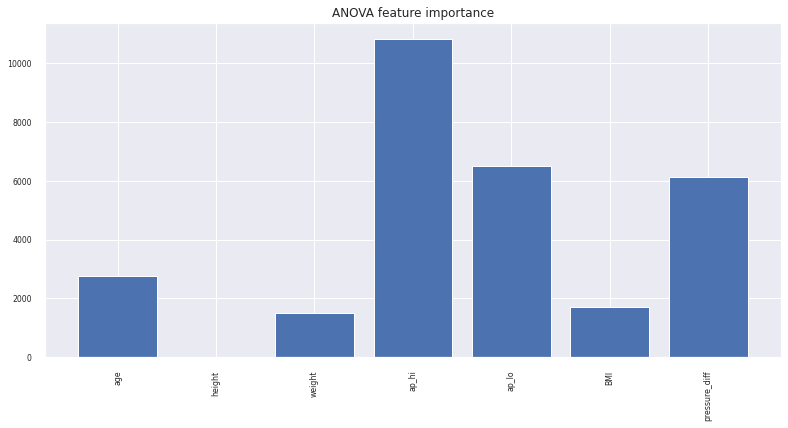

In [59]:
plt.figure(figsize = (11, 6))
plt.xticks(ticks = np.arange(0, select_num_X_train.shape[1]), labels = select_num_X_train.columns, rotation = 90)
plt.title('ANOVA feature importance', size = 12)

for i in range(len(fs.scores_)):
    print('Feature {}: {}'.format(select_num_X_train.columns[i], round(fs.scores_[i], 2)))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.tight_layout()
plt.show()

We might consider removing the height and weight features because the former has a very low impact on predicting the target variable and the latter is highly correlated with the BMI variable, which has a higher importance. Maybe we also don't need the pressure_diff variable because it's highly correlated with the ap_hi, which has a higher importance. 

Now let's use feature selection on the categorical variables. 

In [60]:
select_cat_data = all_data.loc[:train.shape[0]-1, cat_columns]
select_cat_data['cardio'] = train['cardio']

In [61]:
select_cat_X_train, select_cat_X_test, select_cat_y_train, select_cat_y_test \
= train_test_split(select_cat_data.drop('cardio', axis = 1), select_cat_data['cardio'], test_size = 0.33, stratify = select_cat_data['cardio'], shuffle = True, random_state = 83)

In [62]:
OE_cat_sel = OrdinalEncoder()

select_cat_X_train[['BMI_category', 'Pressure_category']] = OE_cat_sel.fit_transform(select_cat_X_train[['BMI_category', 'Pressure_category']])

select_cat_X_test[['BMI_category', 'Pressure_category']] = OE_cat_sel.transform(select_cat_X_test[['BMI_category', 'Pressure_category']])

In [63]:
fs = SelectKBest(score_func = chi2, k = 'all')
fs.fit(select_cat_X_train, select_cat_y_train)
select_cat_X_train_fs = fs.transform(select_cat_X_train)
select_cat_X_test_fs = fs.transform(select_cat_X_test)

Feature gender: 0.43
Feature cholesterol: 792.33
Feature gluc: 97.59
Feature smoke: 7.22
Feature alco: 0.56
Feature active: 11.42
Feature age_group: 259.14
Feature BMI_category: 208.22
Feature Pressure_category: 1962.44


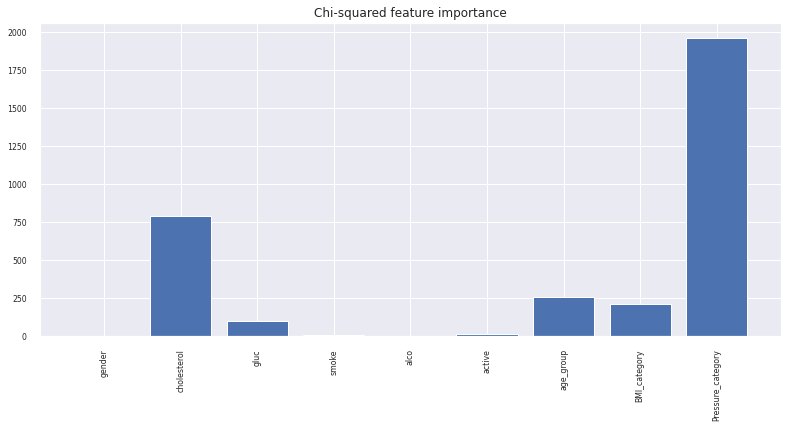

In [64]:
plt.figure(figsize = (11, 6))
plt.xticks(ticks = np.arange(0, select_cat_X_train.shape[1]), labels = select_cat_X_train.columns, rotation = 90)
plt.title('Chi-squared feature importance', size = 12)

for i in range(len(fs.scores_)):
    print('Feature {}: {}'.format(select_cat_X_train.columns[i], round(fs.scores_[i], 2)))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.tight_layout()
plt.show()

We might consider removing the gender, smoke and alco features. Also, the active variable has a very low impact on the target variable.

Let's train and evaluate a baseline model.

In [65]:
RF_classifier = RandomForestClassifier(n_jobs = -1, random_state = 64)

In [66]:
select_data = all_data.loc[:train.shape[0]-1, :]
select_data['cardio'] = train['cardio']

In [67]:
select_data_X = select_data.drop('cardio', axis = 1)
select_data_y = select_data['cardio']

In [68]:
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 11)

In [69]:
def RF_crossval(select_data_X, select_data_y, skf):

  RF_acc = []
  RF_feature_imp = []

  for train_index, test_index in skf.split(select_data_X, select_data_y):
    X_tr, y_tr = select_data_X.iloc[train_index, :], select_data_y.iloc[train_index]
    X_t, y_t = select_data_X.iloc[test_index, :], select_data_y.iloc[test_index]
    
    OE = OrdinalEncoder()
    X_tr[['BMI_category', 'Pressure_category']] = OE.fit_transform(X_tr[['BMI_category', 'Pressure_category']])
    X_t[['BMI_category', 'Pressure_category']] = OE.transform(X_t[['BMI_category', 'Pressure_category']])

    RF_classifier.fit(X_tr, y_tr)
    RF_classifier_preds = RF_classifier.predict(X_t)

    acc = accuracy_score(y_t, RF_classifier_preds)

    RF_acc.append(acc)
    RF_feature_imp.append(RF_classifier.feature_importances_)

  return RF_acc, RF_feature_imp

In [70]:
RF_acc, RF_feature_imp = RF_crossval(select_data_X, select_data_y, skf)

In [71]:
print('Mean accuracy: {}'.format(round(np.mean(RF_acc), 4)))
print('Accuracy std: {}'.format(round(np.std(RF_acc), 4)))

Mean accuracy: 0.708
Accuracy std: 0.0021


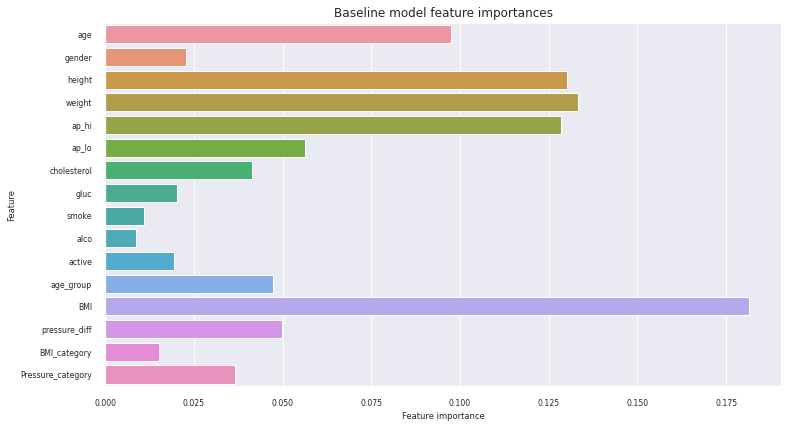

In [72]:
plt.figure(figsize = (11, 6))
sns.barplot(np.mean(RF_feature_imp, axis = 0), select_data_X.columns).set(xlabel = 'Feature importance', ylabel = 'Feature')
plt.title('Baseline model feature importances', fontsize = 12)
plt.tight_layout()
plt.show()

Let's try removing some of the features based on the correlation matrices, filter methods and feature importances obtained from the RF classifier.

Removing the gender, smoke and alco features results in a slight decline in accuracy so we might as well leave them.

Removing the highly correlated numerical features with the lower importance such as weight and pressure_diff results in a very slight decrease as indicated below. To get the best possible quality, we may consider using them as well. However, if we're looking to create the best model in terms of performance, it probably makes sense to drop them. 

For further research, I'm going to use the whole feature set.

In [73]:
feats_to_drop = ['weight', 'pressure_diff']

In [74]:
RF_acc_selected, RF_feature_imp_selected = RF_crossval(select_data_X.drop(feats_to_drop, axis = 1), 
                                                       select_data_y, skf)

In [75]:
print('Mean accuracy: {}'.format(round(np.mean(RF_acc_selected), 4)))
print('Accuracy std: {}'.format(round(np.std(RF_acc_selected), 4)))

Mean accuracy: 0.7058
Accuracy std: 0.0017


# ML application

In this section we're going to create and evaluate two ML models: a Pytorch-based fully-connected neural network (ANN) and an XGBoost Classifier. Hopefully, we can beat the baseline model's accuracy on cross validation. 

In [76]:
class ANN(nn.Module):
  def __init__(self):
    super(ANN, self).__init__()

    self.linear1 = Linear(IN_CHANNELS, 16)
    self.activation1 = ReLU()
    self.batchnorm1 = BatchNorm1d(16)
    self.linear2 = Linear(16, 8)
    self.activation2 = ReLU()
    self.batchnorm2 = BatchNorm1d(8)
    self.linear3 = Linear(8, 1)

  def forward(self, x):

    x = self.linear1(x)
    x = self.activation1(x)
    x = self.batchnorm1(x)
    x = self.linear2(x)
    x = self.activation2(x)
    x = self.batchnorm2(x)
    out = self.linear3(x)

    return out

In [77]:
def train_epoch(model, dataloader):
  
  model.train()
  train_loss, train_correct = 0.0, 0

  for x, y in dataloader:
    optimizer.zero_grad()
    out = model(x.float())
    loss = criterion(out, y.unsqueeze(1).float())
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * x.size(0)
    predictions = t_round(sigmoid(out))
    train_correct += (predictions.squeeze(1) == y).sum().item()

  return train_loss, train_correct

In [78]:
def valid_epoch(model, dataloader):

  model.eval()
  val_loss, val_correct = 0.0, 0

  for x, y in dataloader:
    out = model(x.float())
    loss = criterion(out, y.unsqueeze(1).float())
    val_loss += loss.item() * x.size(0)
    predictions = t_round(sigmoid(out))
    val_correct += (predictions.squeeze(1) == y).sum().item()
  
  return val_loss, val_correct

In [79]:
class CardioDataset(Dataset):
  def __init__(self, X, Y):
    self.x = X.values
    self.y = Y

  def __len__(self):
    return len(self.y)
    
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx] 

In [80]:
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 11)

In [81]:
EPOCHS = 500
BATCH_SIZE = 128
patience = 5

In [82]:
global_train_losses = []
global_test_losses = []
global_train_accuracy = []
global_test_accuracy = []

for fold, (train_index, test_index) in enumerate(skf.split(select_data_X, select_data_y)):
  
  print('FOLD {}'.format(fold + 1))

  select_data_X_scaled = select_data_X.copy()
  ss = StandardScaler()
  ss.fit(select_data_X_scaled.iloc[train_index, [0, 2, 3, 4, 5, 12, 13]])
  select_data_X_scaled.iloc[train_index, [0, 2, 3, 4, 5, 12, 13]] = ss.transform(select_data_X_scaled.iloc[train_index, [0, 2, 3, 4, 5, 12, 13]])
  select_data_X_scaled.iloc[test_index, [0, 2, 3, 4, 5, 12, 13]] = ss.transform(select_data_X_scaled.iloc[test_index, [0, 2, 3, 4, 5, 12, 13]])

  select_data_X_enc = pd.get_dummies(select_data_X_scaled, columns = ['cholesterol',	'gluc', 'BMI_category', 'Pressure_category'],
                                      drop_first = True)

  IN_CHANNELS = select_data_X_enc.shape[1]

  dataset = CardioDataset(select_data_X_enc, select_data_y)

  train_sampler = SubsetRandomSampler(train_index)
  test_sampler = SubsetRandomSampler(test_index)
  train_loader = DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
  test_loader = DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)

  model = ANN()

  criterion = BCEWithLogitsLoss()
  optimizer = Adam(model.parameters(), lr = 0.00001)

  fold_train_losses = []
  fold_test_losses = []
  fold_train_accuracy = []
  fold_test_accuracy = []

  for epoch in range(EPOCHS):

    train_loss, train_correct = train_epoch(model, train_loader)
    test_loss, test_correct = valid_epoch(model, test_loader)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    fold_train_losses.append(train_loss)
    fold_test_losses.append(test_loss)
    fold_train_accuracy.append(train_acc)
    fold_test_accuracy.append(test_acc)

    print('Epoch: {} | Train loss: {} | Train accuracy: {} | Test loss: {} | Test accuracy: {}'.format(epoch+1, round(train_loss, 4), round(train_acc, 3), round(test_loss, 4), round(test_acc, 3)))

    if len(fold_test_losses) > 5:
        if all(i < j for i, j in zip(fold_test_losses[-patience:], fold_test_losses[-patience+1:])):
            print('Test loss is not improving. Early stopping...')
            break
  
  global_train_losses.append(fold_train_losses)
  global_test_losses.append(fold_test_losses)
  global_train_accuracy.append(fold_train_accuracy)
  global_test_accuracy.append(fold_test_accuracy)

FOLD 1
Epoch: 1 | Train loss: 0.7203 | Train accuracy: 50.628 | Test loss: 0.7164 | Test accuracy: 51.903
Epoch: 2 | Train loss: 0.7081 | Train accuracy: 52.664 | Test loss: 0.7024 | Test accuracy: 54.058
Epoch: 3 | Train loss: 0.6971 | Train accuracy: 54.605 | Test loss: 0.6927 | Test accuracy: 55.764
Epoch: 4 | Train loss: 0.6871 | Train accuracy: 56.66 | Test loss: 0.6871 | Test accuracy: 57.877
Epoch: 5 | Train loss: 0.6771 | Train accuracy: 58.242 | Test loss: 0.6725 | Test accuracy: 59.535
Epoch: 6 | Train loss: 0.6672 | Train accuracy: 60.072 | Test loss: 0.6632 | Test accuracy: 61.108
Epoch: 7 | Train loss: 0.6585 | Train accuracy: 61.364 | Test loss: 0.6549 | Test accuracy: 62.295
Epoch: 8 | Train loss: 0.6502 | Train accuracy: 62.493 | Test loss: 0.6492 | Test accuracy: 63.731
Epoch: 9 | Train loss: 0.6424 | Train accuracy: 63.719 | Test loss: 0.6386 | Test accuracy: 64.391
Epoch: 10 | Train loss: 0.635 | Train accuracy: 64.651 | Test loss: 0.6311 | Test accuracy: 65.514
Epoc

In [83]:
#We can see that we got an increase in accuracy on 3-fold cross validation compared to the baseline model

ANN_fold_acc = [i[-1] for i in global_test_accuracy]
print('Mean val accuracy: {}'.format(round(np.mean(ANN_fold_acc), 4)))
print('Mean val std: {}'.format(round(np.std(ANN_fold_acc), 4)))

Mean val accuracy: 73.2614
Mean val std: 0.1238


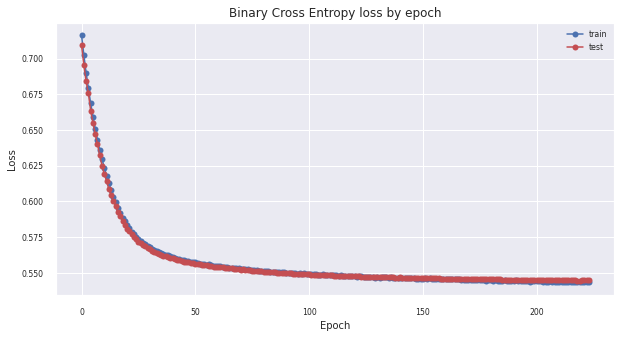

In [85]:
#let's plot mean train and test losses 
#since each fold was training for a different number of epochs, we'll take a slice

min_length = min([len(i) for i in global_train_losses])
global_train_losses_slice = [i[:min_length] for i in global_train_losses]
global_test_losses_slice = [i[:min_length] for i in global_test_losses]

plt.figure(figsize = (10, 5))
plt.plot(np.mean(global_train_losses_slice, axis = 0), 'bo-', label = 'train')
plt.plot(np.mean(global_test_losses_slice, axis = 0), 'ro-', label = 'test')
plt.legend()
plt.xlabel('Epoch', size = 10)
plt.ylabel('Loss', size = 10)
plt.title('Binary Cross Entropy loss by epoch', size = 12);

In [86]:
#let's try XGBoost, first with default params and then after some tuning

In [87]:
xgb = XGBClassifier(learning_rate = 0.1, objective = 'binary:logistic', seed = 42, nthread = -1)

In [88]:
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 11)

In [89]:
def xgb_crossval(select_data_X, select_data_y, skf, xgb):

  xgb_acc = []

  for train_index, test_index in skf.split(select_data_X, select_data_y):
    X_tr, y_tr = select_data_X.iloc[train_index, :], select_data_y.iloc[train_index]
    X_t, y_t = select_data_X.iloc[test_index, :], select_data_y.iloc[test_index]
    
    OE = OrdinalEncoder()
    X_tr[['BMI_category', 'Pressure_category']] = OE.fit_transform(X_tr[['BMI_category', 'Pressure_category']])
    X_t[['BMI_category', 'Pressure_category']] = OE.transform(X_t[['BMI_category', 'Pressure_category']])

    xgb.fit(X_tr, y_tr)
    xgb_preds = xgb.predict(X_t)

    acc = accuracy_score(y_t, xgb_preds)

    xgb_acc.append(acc)

  return xgb_acc

In [90]:
xgb_acc = xgb_crossval(select_data_X, select_data_y, skf = skf, xgb = xgb)

In [91]:
#even the default XGBoost shows a slight improvement compared to the neural network

print('Mean accuracy: {}'.format(round(np.mean(xgb_acc), 4)))
print('Accuracy std: {}'.format(round(np.std(xgb_acc), 4)))

Mean accuracy: 0.7362
Accuracy std: 0.0013


In [92]:
def gridsearch_xgb_crossval(select_data_X, select_data_y, skf, param):

  xgb_acc = []

  for train_index, test_index in skf.split(select_data_X, select_data_y):
    X_tr, y_tr = select_data_X.iloc[train_index, :], select_data_y.iloc[train_index]
    X_t, y_t = select_data_X.iloc[test_index, :], select_data_y.iloc[test_index]
    
    OE = OrdinalEncoder()
    X_tr[['BMI_category', 'Pressure_category']] = OE.fit_transform(X_tr[['BMI_category', 'Pressure_category']])
    X_t[['BMI_category', 'Pressure_category']] = OE.transform(X_t[['BMI_category', 'Pressure_category']])

    params = {'n_estimators': param['n_estimators'],
              'max_depth': param['max_depth'],
              'min_child_weight': param['min_child_weight'],
              'subsample': param['subsample'],
              'colsample_bytree': param['colsample_bytree']
              }
    
    xgb = XGBClassifier(learning_rate = 0.1, objective = 'binary:logistic', seed = 42, nthread = -1)

    xgb.set_params(**params)

    xgb.fit(X_tr, y_tr)
    xgb_preds = xgb.predict(X_t)

    acc = accuracy_score(y_t, xgb_preds)

    xgb_acc.append(acc)

  return np.mean(xgb_acc)

In [93]:
def XGBoost_GridSearchCV(params):
    
    ps = {'accuracy': 0,
          'param': []
    }
    
    
    for prms in tqdm(list(ParameterGrid(params)), ascii = True, desc = 'Parameter Tuning:'):
                          
        acc = gridsearch_xgb_crossval(select_data_X, select_data_y, skf, prms)

        if acc > ps['accuracy']:
            ps['accuracy'] = acc
            ps['param'] = prms
    
    print('Accuracy: ' + str(ps['accuracy']))
    print('Parameters: ' + str(ps['param']))
    
    return ps['param']

In [94]:
params = {'n_estimators': [200, 400, 600, 800],
          'max_depth': [3, 6, 8, 10],
          'min_child_weight': [1, 3, 5],
          'subsample': [0.7, 0.8, 0.9],
          'colsample_bytree': [0.6, 0.7, 0.9]}

In [95]:
param_xgb = XGBoost_GridSearchCV(params)

In [96]:
#the best parameters are {'colsample_bytree': 0.6, 'max_depth': 3, 'min_child_weight': 1,
#'n_estimators': 200, 'subsample': 0.9}

In [97]:
xgb_tuned = XGBClassifier(learning_rate = 0.1,
                          n_estimators = 200,
                          max_depth = 3,
                          min_child_weight = 1,
                          colsample_bytree = 0.6,
                          subsample = 0.9,
                          objective = 'binary:logistic', 
                          seed = 42, nthread = -1)

In [98]:
xgb_tuned_acc = xgb_crossval(select_data_X, select_data_y, skf = skf, xgb = xgb_tuned)

In [99]:
#the tuned xgboost shows a slight improvement compared to the default xgboost

print('Mean accuracy: {}'.format(round(np.mean(xgb_tuned_acc), 4)))
print('Accuracy std: {}'.format(round(np.std(xgb_tuned_acc), 4)))

Mean accuracy: 0.7369
Accuracy std: 0.0004


Now, let's randomly split our dataset into train and validation sets for additional metrics and visualizations.

In [100]:
select_data_X_train, select_data_X_val, select_data_y_train, select_data_y_val = train_test_split(select_data_X, select_data_y, test_size = 0.33, stratify = select_data_y, shuffle = True, random_state = 125)

In [101]:
OE = OrdinalEncoder()

select_data_X_train[['BMI_category', 'Pressure_category']] = OE.fit_transform(select_data_X_train[['BMI_category', 'Pressure_category']])
select_data_X_val[['BMI_category', 'Pressure_category']] = OE.transform(select_data_X_val[['BMI_category', 'Pressure_category']])

In [102]:
XGBoost_classifier = XGBClassifier(learning_rate = 0.1,
                          n_estimators = 200,
                          max_depth = 3,
                          min_child_weight = 1,
                          colsample_bytree = 0.6,
                          subsample = 0.9,
                          objective = 'binary:logistic', 
                          seed = 42, nthread = -1)

In [103]:
XGBoost_classifier.fit(select_data_X_train, select_data_y_train)
xgb_preds = XGBoost_classifier.predict(select_data_X_val)
xgb_probs = XGBoost_classifier.predict_proba(select_data_X_val)

In [104]:
cm = confusion_matrix(select_data_y_val, xgb_preds)

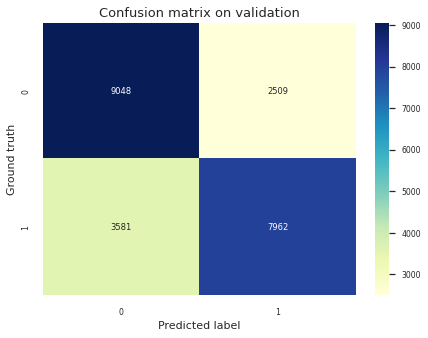

In [105]:
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'YlGnBu')
plt.ylabel('Ground truth', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.title('Confusion matrix on validation', fontsize = 13)
plt.show()

In [106]:
print(classification_report(select_data_y_val, xgb_preds))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     11557
           1       0.76      0.69      0.72     11543

    accuracy                           0.74     23100
   macro avg       0.74      0.74      0.74     23100
weighted avg       0.74      0.74      0.74     23100



The recall for class 1 (heart disease) is noticeably worse than class 0 but in reality we can change the metrics by moving the probability threshold depending on the task at hand. We may want to either prioritize determining if the patient is healthy to avoid wasting money on costly research or find as many potentially ill patients as possible.

In [107]:
precision, recall, thresholds = precision_recall_curve(select_data_y_val, xgb_probs[:, 1])
thresholds = np.append(thresholds, 1)
pr_rec_diff = [abs(p-r) for p, r in zip(precision, recall)]
min_diff_index = pr_rec_diff.index(min(pr_rec_diff))

In [108]:
fpr, tpr, _ = roc_curve(select_data_y_val, xgb_probs[:, 1])

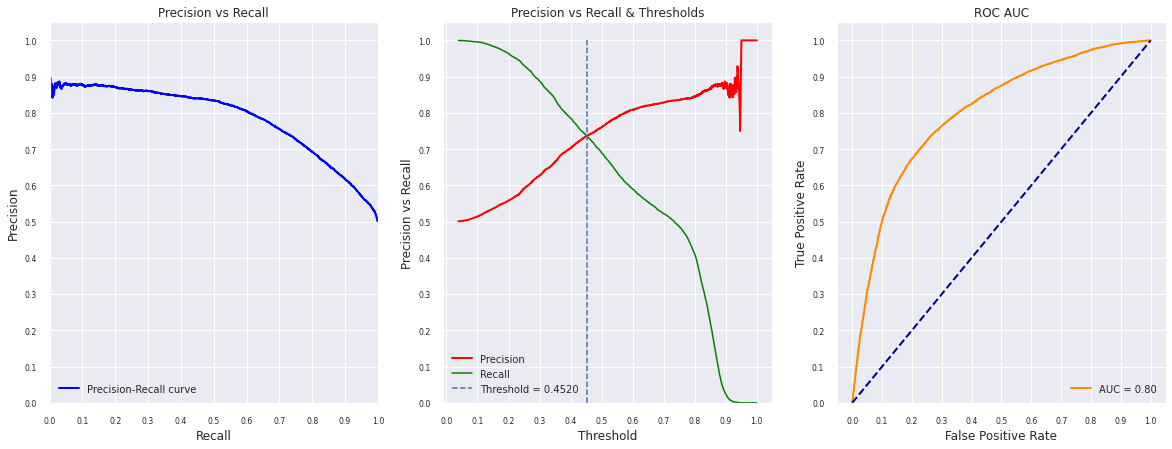

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, sharex = False, sharey = False)
fig.set_size_inches(20, 7)

ax1.plot(recall, precision, color = 'blue', lw = 2, label = 'Precision-Recall curve')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Recall', fontsize = 12)
ax1.set_ylabel('Precision', fontsize = 12)
ax1.set_xticks(np.arange(0, 1.1, step=0.1))
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_title('Precision vs Recall', fontsize = 12)
ax1.legend(loc = "lower left", fontsize = 10)

ax2.plot(thresholds, precision, color = 'red', lw = 2, label = 'Precision')  
ax2.plot(thresholds, recall, color = 'green', label = 'Recall')
ax2.plot([thresholds[min_diff_index], thresholds[min_diff_index]], [0.0, 1.0], '--', label = 'Threshold = %0.4f' % thresholds[min_diff_index])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Threshold', fontsize = 12)  
ax2.set_ylabel('Precision vs Recall', fontsize = 12)
ax2.set_xticks(np.arange(0, 1.1, step=0.1))
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_title('Precision vs Recall & Thresholds', fontsize = 12)
ax2.legend(loc = 'lower left', fontsize = 10)

ax3.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'AUC = %0.2f' % auc(fpr, tpr))  
ax3.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate', fontsize = 12)  
ax3.set_ylabel('True Positive Rate', fontsize = 12)
ax3.set_xticks(np.arange(0, 1.1, step=0.1))
ax3.set_yticks(np.arange(0, 1.1, step=0.1))
ax3.set_title('ROC AUC', fontsize = 12)
ax3.legend(loc = 'lower right', fontsize = 10)

It's always a good idea to provide an estimation of how much each feature affects the predictions. One of the tools that aims to make models interpretable is SHAP.

In [110]:
explainer = shap.TreeExplainer(XGBoost_classifier)
shap_values = explainer.shap_values(select_data_X_val)

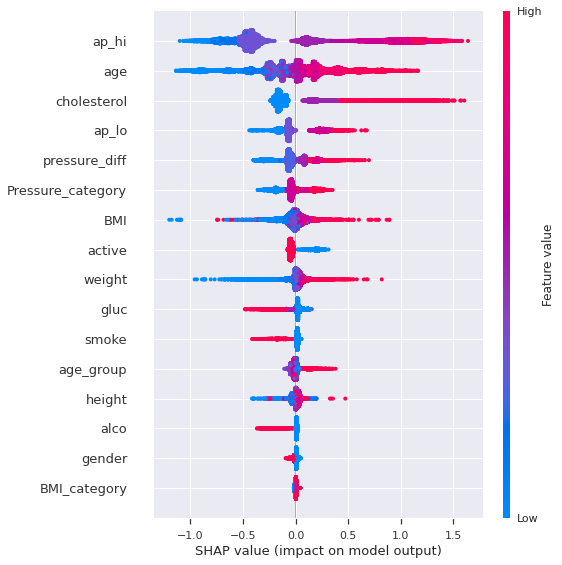

In [111]:
shap.summary_plot(shap_values, features=select_data_X_val, feature_names=select_data_X_val.columns)

Now let's make predictions for the original test set

In [117]:
train_data = all_data.loc[:train.shape[0]-1, :]
train_data['cardio'] = train['cardio']
X_train = train_data.drop('cardio', axis = 1)
y_train = train_data['cardio']

X_test = all_data.loc[train.shape[0]:, :]

In [119]:
OE = OrdinalEncoder()

X_train[['BMI_category', 'Pressure_category']] = OE.fit_transform(X_train[['BMI_category', 'Pressure_category']])
X_test[['BMI_category', 'Pressure_category']] = OE.transform(X_test[['BMI_category', 'Pressure_category']])

In [120]:
XGBoost_classifier.fit(X_train, y_train)
test_preds = XGBoost_classifier.predict(X_test)
test_probs = XGBoost_classifier.predict_proba(X_test)

In [126]:
submission = pd.DataFrame(data = test_probs)

In [128]:
#write to file

submission.to_csv('cardio_submission.csv', index = False)

There are a number of things left to try that might improve the quality of the model:

*   choose a different strategy to handle NaN values. Since we use XGBoost for final predictions, which can process missing data without doing imputation first, it might be a good idea to insert random NAN values into the training dataset to make the data more similar to the test dataset; 
*   generate more features (like polynomials, for example);
*   do additional tuning of the current model;
*   try new models, including ensembles;